In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import sys
sys.path.append("/home/jovyan/PACEfun")
import helper
from dask.distributed import Client
import importlib, helper; importlib.reload(helper)


<module 'helper' from '/home/jovyan/PACEfun/helper.py'>

In [2]:
client = Client()
auth = earthaccess.login("login.netrc")


In [ ]:
# --- TIME ---

tspan = ("2024-03-01 00:00", "2025-09-01 00:00") 
#tspan = ("2024-03-01 00:00", "2024-06-01 00:00")

# --- REGION ---

# 42.69174831596751, 21.058555012396997
region = (41.7, 20.36, 43.7, 22.06)
mid = ( 21.011969, 42.658908 ) #  Kosovo power station
#mid = ( 20.293538, 44.480312 ) # Kolubara A power station
ext = 1.0
region = (mid[0] - ext , mid[1] - ext, mid[0] + ext, mid[1] + ext)
region


(19.293538, 43.480312, 21.293538, 45.480312)

In [14]:
results_spx = earthaccess.search_data(
    short_name="PACE_SPEXONE_L2_AER_RTAPLAND",
    cloud_hosted=True,
    bounding_box=region,
    temporal=tspan,
)
paths_spx = earthaccess.open(results_spx)


QUEUEING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/90 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/90 [00:00<?, ?it/s]

In [15]:
wv = 550
wv_idx = helper.get_wv_idx(paths_spx[0], wv)
crs, shape_tmp, transform_tmp = helper.crs_template(paths_spx[0], "aot", wv)
# Select best data set who covers the most region for the study of interest
shape, transform, _ = helper.grid_aligned_subset(region, transform_tmp, shape_tmp)


In [16]:

kwargs = {"combine": "nested", "concat_dim": "time"}
attrs = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs)
futures = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="aot",
    wv_idx=wv_idx
)
da_spx_aod = xr.combine_nested(client.gather(futures), concat_dim="time")
da_spx_aod["time"] = attrs["time"]


kwargs_ae = {"combine": "nested", "concat_dim": "time"}
attrs_ae = xr.open_mfdataset(paths_spx, preprocess=helper.time_from_attr, **kwargs_ae)
futures_ae = client.map(
    helper.grid_match,
    paths_spx,
    dst_crs=crs,
    dst_shape=shape,
    dst_transform=transform,
    var="angstrom_440_670",
    wv_idx=None
)
da_spx_ae = xr.combine_nested(client.gather(futures_ae), concat_dim="time")
da_spx_ae["time"] = attrs_ae["time"]


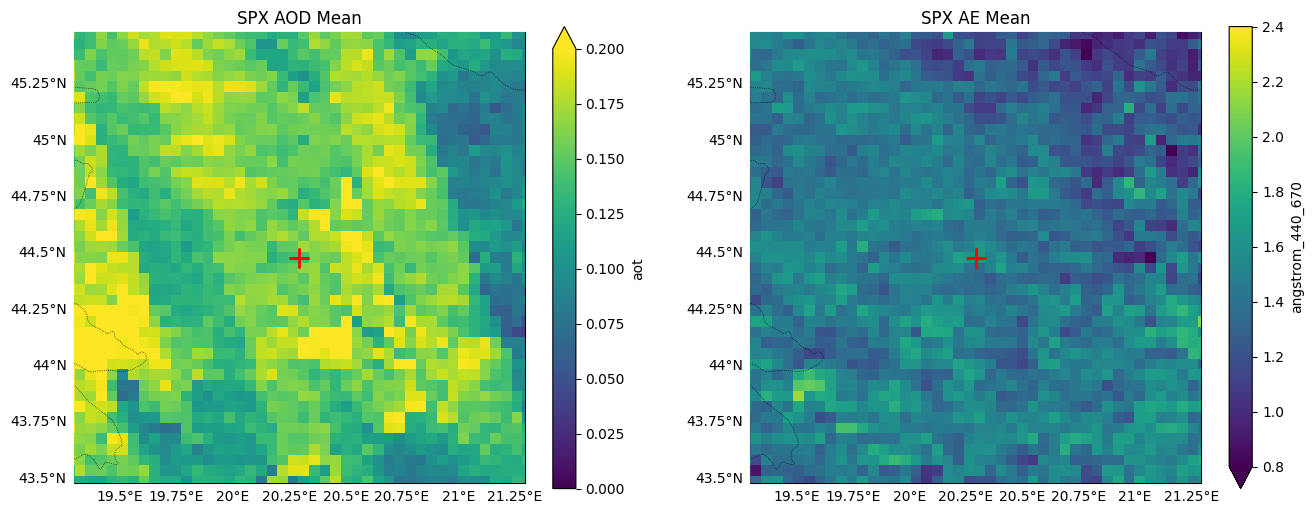

(<Figure size 1600x600 with 4 Axes>,
 [<GeoAxes: title={'center': 'SPX AOD Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>,
  <GeoAxes: title={'center': 'SPX AE Mean'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>])

In [17]:
cross_lonlat = mid

# Static mean panel comparison using helper
helper.plot_mean_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=[0, 0.8],
    vmax=[0.2, 2.4],
    background=None,
    tiles_zoom=12,
)


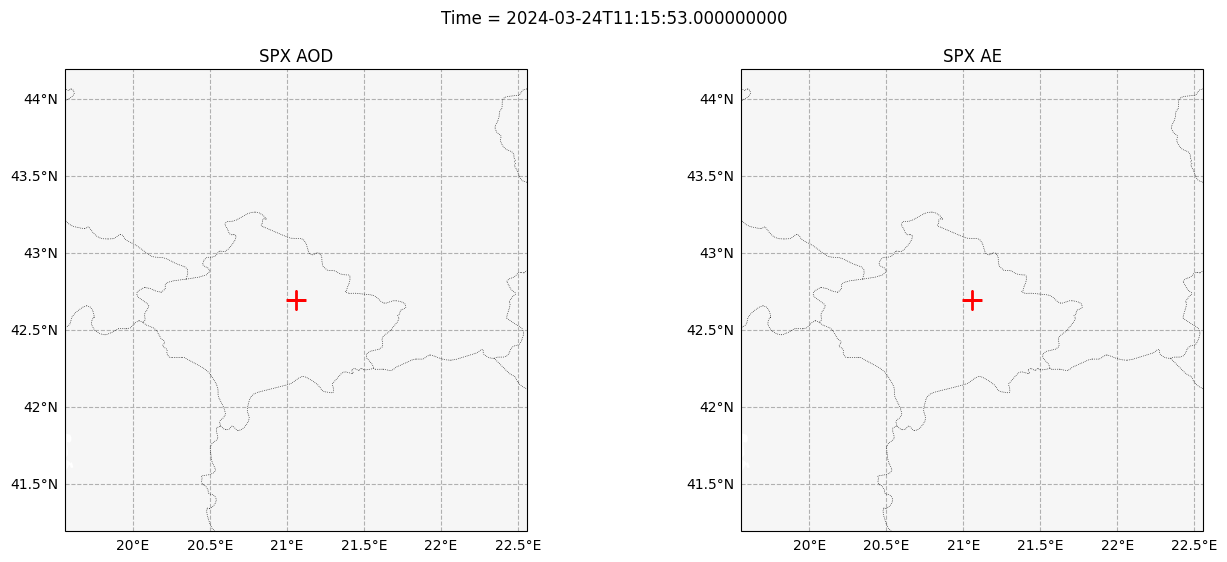

In [8]:
# Time animation using helper
_, _, ani = helper.animate_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD", "SPX AE"],
    crosshair=cross_lonlat,
    cmap="viridis",
    vmin=[0, 0.4],
    vmax=[0.6, 1.6],
    interval=600,
    save_path="PACEfun/movies/spx_oci_comparison.gif",
    writer="pillow",
    dpi=120,
)



In [18]:
# Interactive time slider (Jupyter) using helper
helper.interactive_panels(
    [da_spx_aod, da_spx_ae],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    vmin=[0, 0.4],
    vmax=[0.6, 2.4],
)


interactive(children=(IntSlider(value=0, description='i', max=89), Output()), _dom_classes=('widget-interact',…

<function helper.interactive_panels.<locals>.plot_frame(i)>

<function helper.interactive_panels.<locals>.plot_frame(i)>

In [19]:
def get_overme(da, lon, lat, method="nearest", tolerance=None):
    lon_res = transform[0]
    lat_res = transform[4]
    series = da.sel(longitude=lon, latitude=lat, method=method)
    mask = series.notnull()
    for scale in range(1,8):
        series = da.sel(longitude=lon+scale * lon_res, latitude=scale * lat, method=method)
        mask = series.notnull() | mask
        mask = series.notnull()
        series = da.sel(longitude=lon-lon_res, latitude=lat, method=method)
        mask = series.notnull() | mask
        series = da.sel(longitude=lon, latitude=lat+scale * lat_res, method=method)
        mask = series.notnull() | mask
        series = da.sel(longitude=lon, latitude=lat-scale * lat_res, method=method)
        mask = series.notnull() | mask
    mask_xr = xr.DataArray(mask.values, dims=["time"], coords={"time": da.time})
    da_masked = da.where(mask_xr, drop=True)
    return da_masked


da_spx_aod_filter = get_overme(da_spx_aod, *cross_lonlat)
da_spx_ae_filter = get_overme(da_spx_ae, *cross_lonlat)


In [ ]:
helper.interactive_panels(
    [da_spx_aod_filter, da_spx_ae_filter],
    region=region,
    titles=["SPX AOD Mean", "SPX AE Mean"],
    crosshair=cross_lonlat,
    vmin=[0, 0.4],
    vmax=[0.3, 2.4],
)


interactive(children=(IntSlider(value=0, description='i', max=10), Output()), _dom_classes=('widget-interact',…

<function helper.interactive_panels.<locals>.plot_frame(i)>

<function helper.interactive_panels.<locals>.plot_frame(i)>

In [33]:
lon

<xarray.DataArray 'longitude' (longitude: 44)> Size: 352B
array([19.272672, 19.319945, 19.367219, 19.414492, 19.461766, 19.509039,
       19.556313, 19.603587, 19.65086 , 19.698134, 19.745407, 19.792681,
       19.839954, 19.887228, 19.934502, 19.981775, 20.029049, 20.076322,
       20.123596, 20.170869, 20.218143, 20.265417, 20.31269 , 20.359964,
       20.407237, 20.454511, 20.501785, 20.549058, 20.596332, 20.643605,
       20.690879, 20.738152, 20.785426, 20.8327  , 20.879973, 20.927247,
       20.97452 , 21.021794, 21.069067, 21.116341, 21.163615, 21.210888,
       21.258162, 21.305435])
Coordinates:
  * longitude    (longitude) float64 352B 19.27 19.32 19.37 ... 21.26 21.31
    spatial_ref  int64 8B 0
Attributes:
    axis:           X
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [34]:
mid

(20.293538, 44.480312)

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


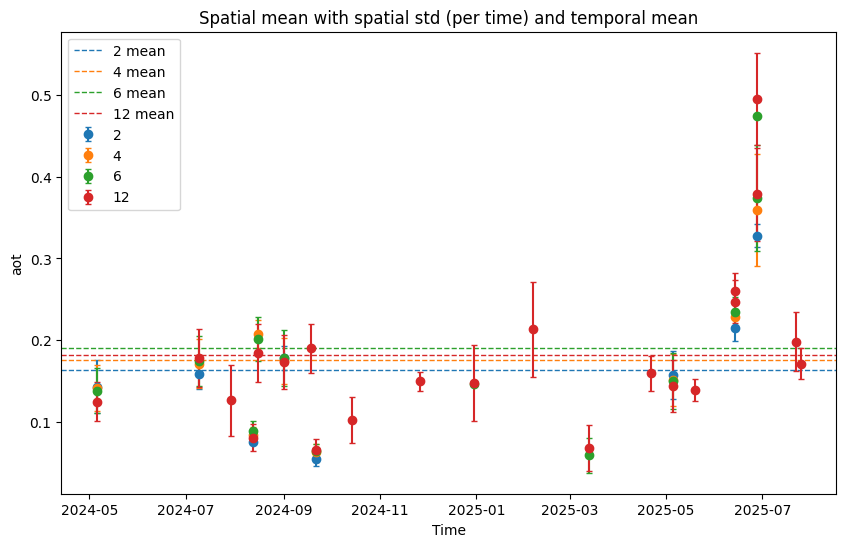

/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/srv/conda/envs/notebook/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


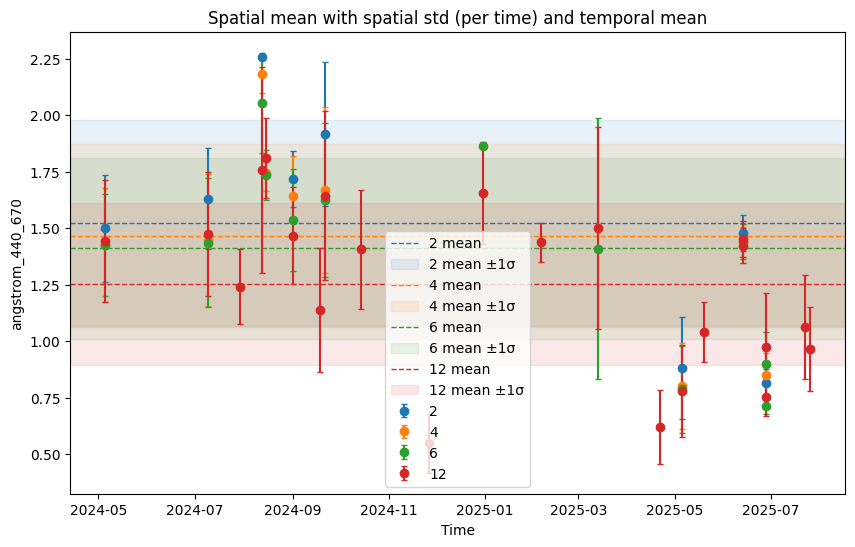

In [76]:
def area_plot(da, lon_res, lat_res, mid, factor=1):

  # L1
  lon = da.longitude
  lat = da.latitude
  '''

  da_filtered = da.where( 
                  ( mid[1] - factor * lat_res < lat ) & ( mid[1] + factor * lat_res > lat ) &
                  ( mid[0] - factor * lon_res < lon ) & ( mid[0] + factor * lon_res > lon ),
                  drop=True
                )
  '''
  # L2
  radius = factor * lat_res  # radius in degrees (approx)

  da_filtered = da.where(
      ((lat - mid[1])**2 + (lon - mid[0])**2) < radius**2,
      drop=True
  )
  return da_filtered
    
import matplotlib as mpl

def n_area_plot(da, transform, mid, factors=None, n=1, show_temporal_band=False, capsize=2):

    prop_cycler = plt.rcParams['axes.prop_cycle']()

    """
    Plot spatial mean time series (scatter) with spatial std as error bars per time step.
    Draw a horizontal line at the temporal mean in the same color.
    
    Args:
        da: xarray.DataArray with dims including ["time", "latitude", "longitude"].
        transform: affine-like tuple; we only use its x/y resolutions.
        mid: (lon, lat) center.
        factors: iterable of factors (e.g., [1,2,4]) to size the circular area. If None, uses range(1, n).
        n: upper bound for range if factors is None.
        show_temporal_band: if True, also shade mean ± 1σ over time.
        capsize: cap size for error bars.
    """
    # Keep your original convention
    lat_res = np.abs(transform[0])
    lon_res = np.abs(transform[4])

    fig, ax = plt.subplots(figsize=(10, 6))

    seq = factors if factors is not None else range(1, n)

    for f in seq:
        da_f = area_plot(da, lon_res, lat_res, mid, f)

        # Spatial mean & std per time step
        mean_ts = da_f.mean(dim=["longitude", "latitude"])
        std_ts  = da_f.std(dim=["longitude", "latitude"])

        # Drop times with all-NaN mean; align std accordingly
        mean_valid = mean_ts.dropna(dim="time")
        std_valid = std_ts.sel(time=mean_valid.time)

        # Get next color in cycle
        color = next(prop_cycler)['color']


        # Scatter with error bars (no connecting lines)
        ax.errorbar(
            mean_valid["time"].values,
            mean_valid.values,
            yerr=std_valid.values,
            fmt="o",
            linestyle="None",
            color=color,
            capsize=capsize,
            label=f"{f}"
        )

        # Temporal mean (horizontal) in the same color
        time_mean = float(mean_valid.mean().values)
        ax.axhline(time_mean, color=color, linestyle="--", linewidth=1.0, label=f"{f} mean")

        # Optional: shade temporal mean ± 1σ
        if show_temporal_band:
            time_std = float(mean_valid.std().values)
            ax.axhspan(time_mean - time_std, time_mean + time_std, color=color, alpha=0.10,
                       label=f"{f} mean ±1σ")

    ax.set_title("Spatial mean with spatial std (per time) and temporal mean")
    ax.set_xlabel("Time")
    ax.set_ylabel(getattr(da, "name", "value"))
    ax.legend()
    plt.show()


# Examples (array of factors instead of range)
n_area_plot(da_spx_aod, transform, mid, factors=[2,4,6,12], show_temporal_band=False)
n_area_plot(da_spx_ae,  transform, mid, factors=[2,4,6,12], show_temporal_band=True)
